# Exploratory Data Analysis 

This notebook serves to find strong predictors, correlations and dependencies between the available data

## 0. Import Dependencies

In [46]:
import pandas as pd
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px 

from IPython.display import display

In [2]:
SEED = 42
np.random.seed(SEED)

## 1. Plot Settings

In [24]:
# seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

# matplotlib general settings
plt.rcParams['figure.figsize'] = (5, 3)  # default figure size
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['grid.alpha'] = 0.3

In [ ]:
# reproducibility
RANDOM_STATE = SEED

In [20]:
# custom color palette
colors = {
    'rosa': '#F4A3B8',     
    'pink': '#FF69B4',     
    'orange': '#FFA500',   
    'yellow': '#FFD700',   
    'red': '#FF4500',      
    'lilac': '#C8A2C8',    
}

sns.set_palette(list(colors.values()))

In [6]:
# display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data 

In [13]:
# directory datasets
PROCESSED_DIR = Path("data/processed")

# dataset names list 
dataset_name = [
    "domestic",
    "vawg",
    "freedom",
    "danger",
    "gdp",
    "wage_gap",
    "unemployment",
    "gii",
    "legal",
    "partner_violence",
    "eq_laws"
]

# helper function loading all dfs
def load_all_datasets(dataset_names, path=PROCESSED_DIR):
    datasets = {}
    for name in dataset_names:
        file_path = path / f"{name}.csv"
        try:
            df = pd.read_csv(file_path)
            datasets[name] = df
            print(f"Loaded: {name} ({df.shape[0]} rows, {df.shape[1]} cols)")
        except FileNotFoundError:
            print(f"Warning: {file_path} not found.")
    return datasets

# load all datasets
datasets = load_all_datasets(dataset_name)

# individual dataset
dv_df = datasets["domestic"]
vawg_df = datasets["vawg"]
gdp_df = datasets["gdp"]
hfi_df = datasets["freedom"]
mdc_df = datasets["danger"]
gwg_df = datasets["wage_gap"]
gud_df = datasets["unemployment"]
gii_df = datasets["gii"]
lf_df = datasets["legal"]
aip_df = datasets["partner_violence"]
gel_df = datasets["eq_laws"]

Loaded: domestic (347 rows, 6 cols)
Loaded: vawg (415 rows, 19 cols)
Loaded: freedom (165 rows, 6 cols)
Loaded: danger (50 rows, 9 cols)
Loaded: gdp (259 rows, 3 cols)
Loaded: wage_gap (43 rows, 2 cols)
Loaded: unemployment (1134 rows, 5 cols)
Loaded: gii (195 rows, 12 cols)
Loaded: legal (127 rows, 3 cols)
Loaded: partner_violence (151 rows, 3 cols)
Loaded: eq_laws (7 rows, 8 cols)


## 3. Individual-Level Analysis (domestic dataset)

### 2.1 Univariate Analysis

**Key Questions**
- age distribution: certain age groups overrepresented?
- income distribution: is it skewed? any extreme values?
- Education/Employment/Marital Status: What are the category frequencies?
- Violence rate: What's the baseline prevalence? --> **TARGET VARIABLE!**

**Steps**:

*for each variable*
- distribution plots (histogram age/income, bar chart cat col)
- summary stats 
- oulier check (age/income)

In [17]:
# summary statistics
dv_df.describe(include='all')

,age,education,employment,income,marital_status,violence
count,347.00,347,347,347.00,347,347
unique,NaN,4,3,NaN,2,2
top,NaN,primary,unemployed,NaN,married,no
freq,NaN,132,274,NaN,300,261
mean,31.38,NaN,NaN,2110.69,NaN,NaN
std,9.60,NaN,NaN,5743.28,NaN,NaN
min,15.00,NaN,NaN,0.00,NaN,NaN
25%,23.00,NaN,NaN,0.00,NaN,NaN
50%,30.00,NaN,NaN,0.00,NaN,NaN
75%,39.50,NaN,NaN,0.00,NaN,NaN


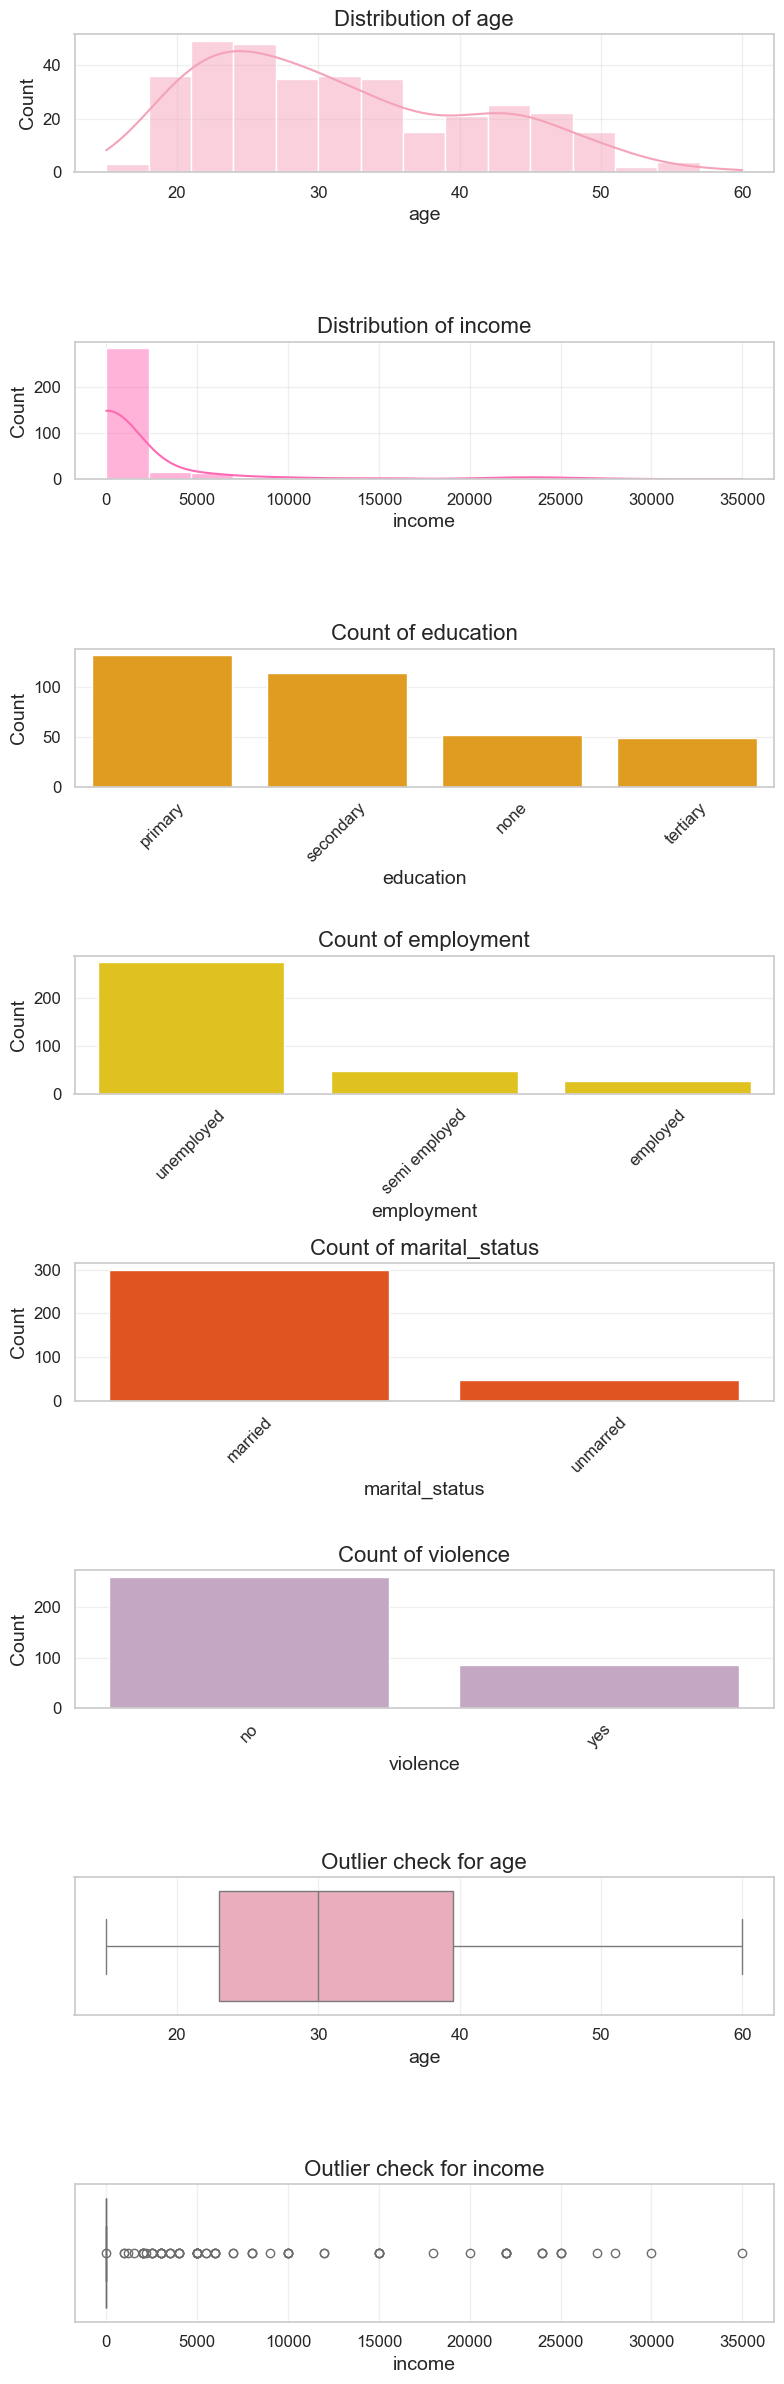

Outliers in age:
Series([], Name: age, dtype: int64)

Outliers in income:
328    20000
329    22000
330    22000
331    22000
332    22000
333    22000
334    24000
335    24000
336    24000
337    25000
338    25000
339    25000
340    27000
341    28000
342    30000
343    35000
Name: income, dtype: int64



In [31]:
# define num/cat
num_col_dv = ["age", "income"]
cat_col_dv = ["education", "employment", "marital_status", "violence"]

# figures
total_plots = len(num_col_dv) + len(cat_col_dv) + len(num_col_dv)
fig, axes = plt.subplots(total_plots, 1, figsize=(8, total_plots*3))
axes = axes.flatten()  

# color palette
palette = list(colors.values())

plot_idx = 0

# numeric histograms
for i, col in enumerate(num_col_dv):
    sns.histplot(dv_df[col].dropna(), kde=True, color=palette[i % len(palette)], ax=axes[plot_idx], bins=15)
    axes[plot_idx].set_title(f"Distribution of {col}")
    axes[plot_idx].set_xlabel(col)
    axes[plot_idx].set_ylabel("Count")
    plot_idx += 1

# categorical bar plots
for i, col in enumerate(cat_col_dv):
    sns.countplot(
        data=dv_df,
        x=col,
        order=dv_df[col].value_counts().index,
        color=palette[(i+len(num_col_dv)) % len(palette)],
        ax=axes[plot_idx]
    )
    axes[plot_idx].set_title(f"Count of {col}")
    axes[plot_idx].set_xlabel(col)
    axes[plot_idx].set_ylabel("Count")
    axes[plot_idx].tick_params(axis='x', rotation=45)
    plot_idx += 1

# boxplot outlier check
for i, col in enumerate(num_col_dv):
    sns.boxplot(x=dv_df[col], color=palette[(i+len(num_col_dv)+len(cat_col_dv)) % len(palette)], ax=axes[plot_idx])
    axes[plot_idx].set_title(f"Outlier check for {col}")
    plot_idx += 1

plt.tight_layout()
plt.show()

# print outliers
for col in num_col_dv:
    z_scores = zscore(dv_df[col].dropna())
    outliers = dv_df[col][np.abs(z_scores) > 3]
    print(f"Outliers in {col}:\n{outliers}\n")

### 1.2 Bivariate Analysis

**Key Questions**
- Which employment status has highest violence rate?
- Does violence vary by marital status?
- Is there an age effect?
- Income correlation with violence?

**Steps**:

*violence vs each predictor*
- Chi-square tests for categorical variables
- T-tests or Mann-Whitney U for continuous variables
- Visualize with grouped bar charts and box plots


=== education vs violence ===
violence   no  yes
education         
none       41   11
primary    86   46
secondary  94   20
tertiary   40    9
Chi-square test: chi2=11.83, p=0.0080


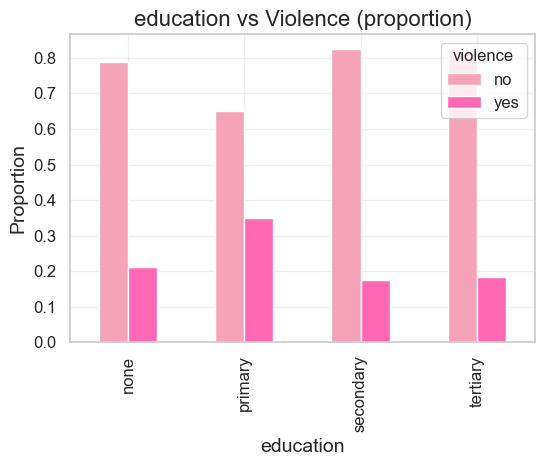


=== employment vs violence ===
violence        no  yes
employment             
employed        20    6
semi employed   42    5
unemployed     199   75
Chi-square test: chi2=6.07, p=0.0481


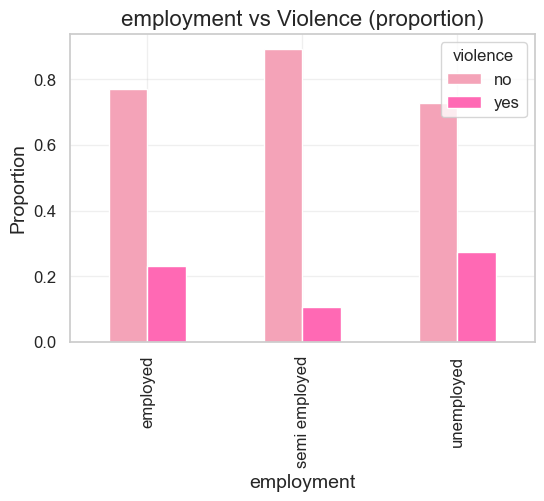


=== marital_status vs violence ===
violence         no  yes
marital_status          
married         217   83
unmarred         44    3
Chi-square test: chi2=8.77, p=0.0031


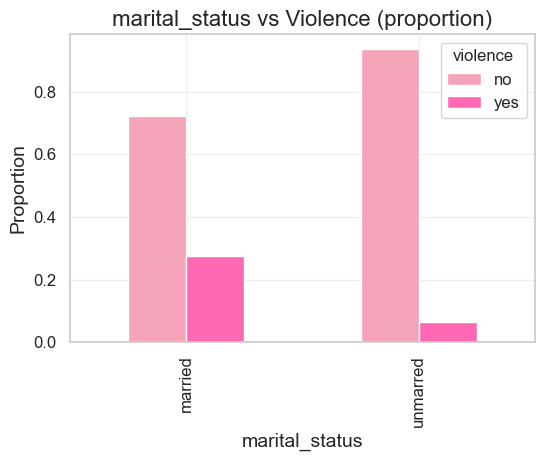


=== violence vs violence ===
violence   no  yes
violence          
no        261    0
yes         0   86
Chi-square test: chi2=341.66, p=0.0000


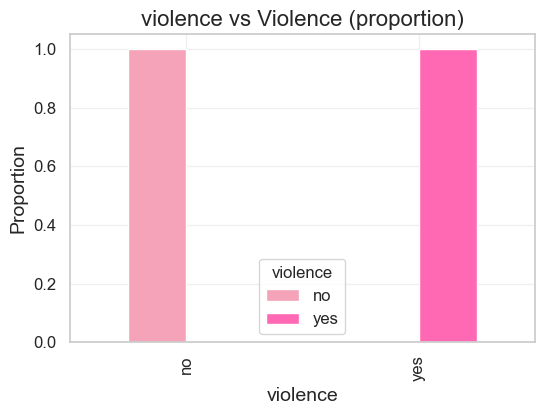

In [ ]:
# categorical values vs violence

for col in cat_col_dv:
    print(f"\n=== {col} vs violence ===")
    
    # contingency table
    ct = pd.crosstab(dv_df[col], dv_df["violence"])
    print(ct)
    
    # Chi-square test
    chi2, p, dof, ex = stats.chi2_contingency(ct)
    print(f"Chi-square test: chi2={chi2:.2f}, p={p:.4f}")
    
    # grouped bar plot
    ct_prop = ct.div(ct.sum(axis=1), axis=0)
    ct_prop.plot(kind='bar', stacked=False, color=palette[:len(ct_prop)], figsize=(6,4))
    plt.title(f"{col} vs Violence (proportion)")
    plt.ylabel("Proportion")
    plt.show()


=== age vs violence ===
Mann-Whitney U: stat=13541.50, p=0.0040


C:\Users\black\AppData\Local\Temp\ipykernel_35936\2167476297.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="violence", y=col, data=dv_df, palette=palette[:2])


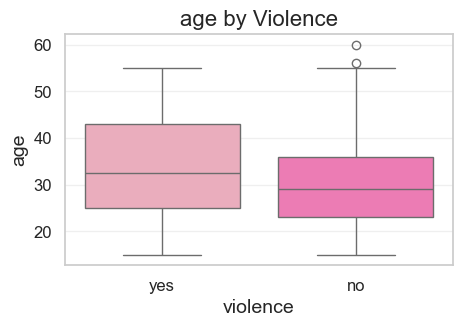


=== income vs violence ===
Mann-Whitney U: stat=9853.00, p=0.0184


C:\Users\black\AppData\Local\Temp\ipykernel_35936\2167476297.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="violence", y=col, data=dv_df, palette=palette[:2])


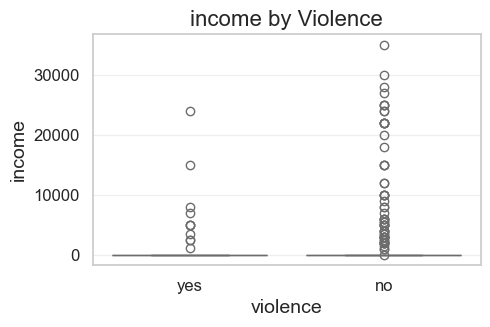

In [33]:
# numerical values vs violence

for col in num_col_dv:
    print(f"\n=== {col} vs violence ===")
    
    # Split by violence
    group_yes = dv_df.loc[dv_df["violence"]=="yes", col].astype(float)
    group_no = dv_df.loc[dv_df["violence"]=="no", col].astype(float)
    
    # Normality check
    stat_yes, p_yes = stats.shapiro(group_yes)
    stat_no, p_no = stats.shapiro(group_no)
    
    if p_yes>0.05 and p_no>0.05:
        # parametric test
        stat, p_val = stats.ttest_ind(group_yes, group_no, equal_var=False)
        test_type = "T-test"
    else:
        # non-parametric test
        stat, p_val = stats.mannwhitneyu(group_yes, group_no)
        test_type = "Mann-Whitney U"
        
    print(f"{test_type}: stat={stat:.2f}, p={p_val:.4f}")
    
    # Boxplot
    sns.boxplot(x="violence", y=col, data=dv_df, palette=palette[:2])
    plt.title(f"{col} by Violence")
    plt.show()


### 1.3 Multivariate Analysis 

**Steps**:
- Correlation matrix for age and income
- Crosstabs for categorical combinations (e.g. employment × marital_status × violence)
- Segmentation analysis: creating profiles of high-risk vs. low-risk groups

In [35]:
# age income correlation
dv_df["income"] = dv_df["income"].astype(float)
dv_df["age"] = dv_df["age"].astype(float)
dv_df["violence_binary"] = dv_df["violence"].map({"yes":1, "no":0})

for col in ["age", "income"]:
    corr, p = stats.pearsonr(dv_df[col], dv_df["violence_binary"])
    print(f"Correlation of {col} with violence: r={corr:.2f}, p={p:.4f}")

Correlation of age with violence: r=0.17, p=0.0018
Correlation of income with violence: r=-0.12, p=0.0258


Crosstab: Employment × Marital Status × Violence
violence                       no  yes
employment    marital_status          
employed      married        0.75 0.25
              unmarred       1.00 0.00
semi employed married        0.86 0.14
              unmarred       1.00 0.00
unemployed    married        0.70 0.30
              unmarred       0.91 0.09
All                          0.75 0.25


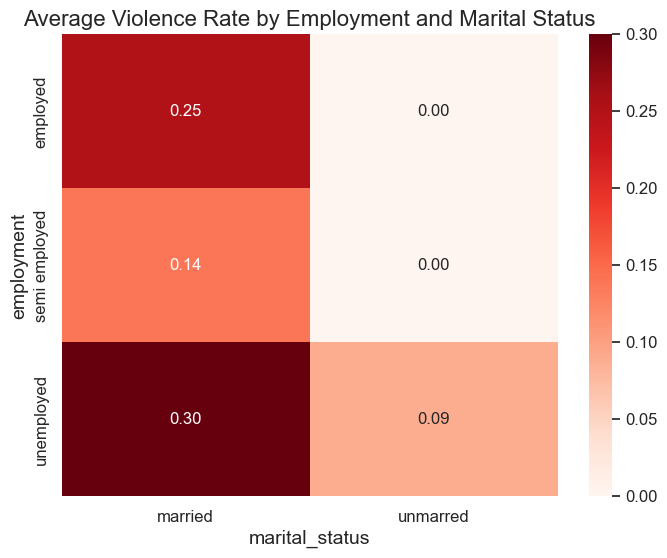

In [36]:
# multi-way crosstab
multi_ct = pd.crosstab(
    index=[dv_df['employment'], dv_df['marital_status']],
    columns=dv_df['violence'],
    margins=True,  
    normalize='index' 
)
print("Crosstab: Employment × Marital Status × Violence")
print(multi_ct)

# heatmap visualization
plt.figure(figsize=(8,6))
sns.heatmap(
    pd.crosstab(dv_df['employment'], dv_df['marital_status'], values=dv_df['violence'].map({'yes':1,'no':0}), aggfunc='mean'),
    annot=True, fmt=".2f",
    cmap="Reds"
)
plt.title("Average Violence Rate by Employment and Marital Status")
plt.show()

       employment marital_status  education  violence_rate  count risk_profile
0        employed        married    primary           0.60      5    high-risk
11     unemployed        married    primary           0.37    111    high-risk
13     unemployed        married   tertiary           0.35     17    high-risk
14     unemployed       unmarred    primary           0.33      3    high-risk
6   semi employed        married  secondary           0.27     11    high-risk
1        employed        married  secondary           0.25      4    high-risk
10     unemployed        married       none           0.23     43     low-risk
12     unemployed        married  secondary           0.22     69     low-risk
2        employed        married   tertiary           0.13     15     low-risk
4   semi employed        married       none           0.11      9     low-risk
16     unemployed       unmarred   tertiary           0.10     10     low-risk
5   semi employed        married    primary         

C:\Users\black\AppData\Local\Temp\ipykernel_35936\2147597918.py:21: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(


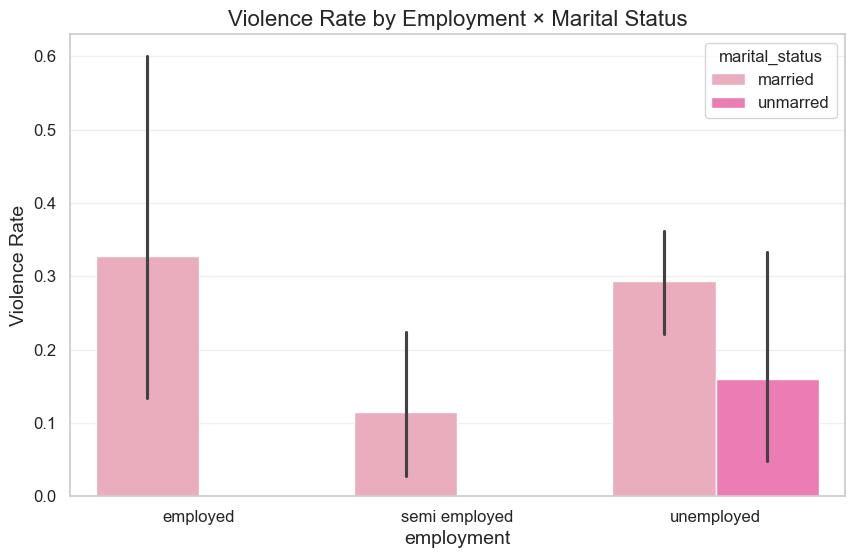

In [37]:
# creating a risk score using violence probability and categorical values

# convert categorical variables to binary dummies for simple scoring
risk_df = dv_df.copy()
risk_df['violence_binary'] = risk_df['violence'].map({'yes':1,'no':0})

# group by key categorical variables
grouped = risk_df.groupby(['employment','marital_status','education']).agg(
    violence_rate=('violence_binary','mean'),
    count=('violence_binary','size')
).reset_index()

# high-risk vs low-risk
threshold = risk_df['violence_binary'].mean()  # overall mean violence rate
grouped['risk_profile'] = grouped['violence_rate'].apply(lambda x: 'high-risk' if x>threshold else 'low-risk')

print(grouped.sort_values('violence_rate', ascending=False))

# visualize
plt.figure(figsize=(10,6))
sns.barplot(
    x='employment',
    y='violence_rate',
    hue='marital_status',
    data=grouped,
    palette=palette[:3]
)
plt.title("Violence Rate by Employment × Marital Status")
plt.ylabel("Violence Rate")
plt.show()

## 4. Country-Level Analysis

### 4.2 Freedom & Danger Indices

#### 4.2.1 Freedom Datset

- How do hf_score, pf_score, ef_score correlate with each other?
- Which freedom dimension matters most?


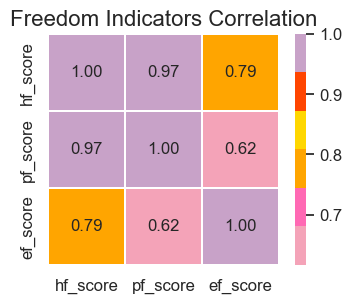

In [48]:
# freedom  correlation analysis
freedom_scores = hfi_df[["hf_score", "pf_score", "ef_score"]]

# corr matrix
corr_freedom = freedom_scores.corr()

# plt heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(
    corr_freedom,
    annot=True,
    cmap=list(colors.values()), 
    fmt=".2f",
    linewidths=0.3,
    square=True
)
plt.title("Freedom Indicators Correlation")
plt.show()


!hf score is most likely a combined calculation from the ef & pf score! -> redundant data

- hf = human freedom
- ef = economic freedom
- pf = personal freedom

#### 4.2.2 Danger Dataset

- Create correlation heatmap of all 10 indices
- Identify which indices cluster together (PCA)
- Some indices might be redundant (e.g. WPSI vs WDI)

In [53]:
mdc_old = pd.read_csv(r"data/clean/arpitsinghaiml_most-dangerous-countries-for-women-2024_cleaned.csv")

mdc_old = mdc_old.rename(columns={
    "mostdangerouscountriesforwomen_womenpeaceandsecurityindex_score_2023" : "wpsi",
    "mostdangerouscountriesforwomen_womensdangerindexwdi_totalscore_2019" : "wdi",
    "mostdangerouscountriesforwomen_wdistreetsafety_2019" : "wss",
    "mostdangerouscountriesforwomen_wdiintentionalhomicide_2019" : "ih",
    "mostdangerouscountriesforwomen_wdinonpartnerviolence_2019" : "npv",
    "mostdangerouscountriesforwomen_wdiintimatepartnerviolence_2019" : "ipv",
    "mostdangerouscountriesforwomen_wdilegaldiscrimination_2019" : "ld",
    "mostdangerouscountriesforwomen_wdiglobalgendergap_2019" : "ggg",
    "mostdangerouscountriesforwomen_wdigenderinequality_2019" : "gi",
    "mostdangerouscountriesforwomen_wdiattitudestowardviolence_2019" : "atv"
    })

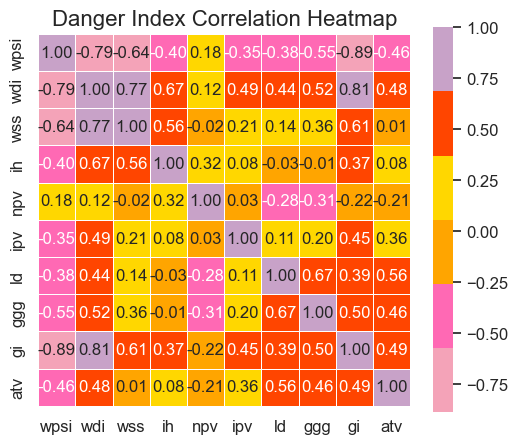

      wpsi   wdi   wss    ih   npv   ipv    ld   ggg    gi   atv
wpsi  1.00 -0.79 -0.64 -0.40  0.18 -0.35 -0.38 -0.55 -0.89 -0.46
wdi  -0.79  1.00  0.77  0.67  0.12  0.49  0.44  0.52  0.81  0.48
wss  -0.64  0.77  1.00  0.56 -0.02  0.21  0.14  0.36  0.61  0.01
ih   -0.40  0.67  0.56  1.00  0.32  0.08 -0.03 -0.01  0.37  0.08
npv   0.18  0.12 -0.02  0.32  1.00  0.03 -0.28 -0.31 -0.22 -0.21
ipv  -0.35  0.49  0.21  0.08  0.03  1.00  0.11  0.20  0.45  0.36
ld   -0.38  0.44  0.14 -0.03 -0.28  0.11  1.00  0.67  0.39  0.56
ggg  -0.55  0.52  0.36 -0.01 -0.31  0.20  0.67  1.00  0.50  0.46
gi   -0.89  0.81  0.61  0.37 -0.22  0.45  0.39  0.50  1.00  0.49
atv  -0.46  0.48  0.01  0.08 -0.21  0.36  0.56  0.46  0.49  1.00


In [55]:
# corr heatmap danger 
mdc_cols = ["wpsi", "wdi", "wss", "ih", "npv", "ipv", "ld", "ggg", "gi", "atv"]
mdc_scores = mdc_old[mdc_cols]

corr_mdc = mdc_scores.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_mdc,
    annot=True,
    cmap=list(colors.values()), 
    fmt=".2f",
    linewidths=0.4,
    square=True
)
plt.title("Danger Index Correlation Heatmap")
plt.show()

print(corr_mdc)

1. pattern: general danger-inequality dimension
- wpsi <-> gi: -0.89 -> very high inverser corr
- etc
    --> the higher gender inequality, women danger index, women safety & security, ggg, ld, etc., the lower the women peace & security index

2. violence-specific dimension:
- ipv, npv, atv


Explained variance by component:
PC1: 46.37%
PC2: 19.53%
PC3: 10.28%


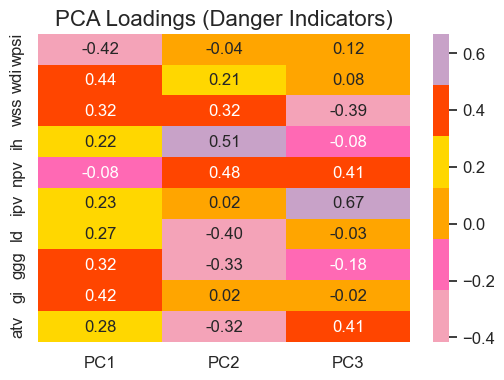


PCA Loadings Table:
       PC1   PC2   PC3
wpsi -0.42 -0.04  0.12
wdi   0.44  0.21  0.08
wss   0.32  0.32 -0.39
ih    0.22  0.51 -0.08
npv  -0.08  0.48  0.41
ipv   0.23  0.02  0.67
ld    0.27 -0.40 -0.03
ggg   0.32 -0.33 -0.18
gi    0.42  0.02 -0.02
atv   0.28 -0.32  0.41


In [57]:
# PCA

# drop NaN & standardize
mdc_clean = mdc_scores.dropna()

scaler = StandardScaler()
mdc_scaled = scaler.fit_transform(mdc_clean)

# pca
pca = PCA(n_components=3, random_state=RANDOM_STATE)
pca_fit = pca.fit(mdc_scaled)

print("\nExplained variance by component:")
for i, v in enumerate(pca_fit.explained_variance_ratio_, 1):
    print(f"PC{i}: {v:.2%}")

# visualize
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i}" for i in range(1, 4)],
    index=mdc_cols
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    loadings,
    annot=True,
    cmap=list(colors.values()),
    fmt=".2f"
)
plt.title("PCA Loadings (Danger Indicators)")
plt.show()

print("\nPCA Loadings Table:")
print(loadings)

**PC1 Global Danger & Gender Inequality**
- wdi, gi, ggg, wss, ld --> high positive leads to wpsi --> high negative
- represents general danger

**PC2 Interpersonal Violence vs Structural Discrimination**
- ih, npv --> interpersonal violence
- ld, ggg --> institutional discrimination
- dofferent forms of harm

**PC3 Intimate & Non Partner Violence**
- ipv & npv --> interpersonal relationships isolated from broader danger

### 4.3 Economic Indicators